Import Packages

In [28]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Read excel files into Pandas DataFrames

In [30]:
pd.set_option("display.max_columns", None)

In [31]:
trump_df = pd.read_csv('new_data/trump_sentiment_analysis_new_with_sentiment.csv')
kamala_df = pd.read_csv('new_data/harris_sentiment_analysis_new_with_sentiment.csv')

print(trump_df.shape)
print(kamala_df.shape)

(125635, 26)
(433979, 26)


Vertically concatenate Trump and Harris dataframes (automatically matches columns)

In [33]:
all_tweets = pd.concat([kamala_df,trump_df])
all_tweets.reset_index(drop=True)
all_tweets.shape

(559614, 26)

Select necessary columns for time scale

In [35]:
columns = ['Date','Tweet Text','Kamala_Sentiment', 'Kamala_Score',
       'Trump_Sentiment', 'Trump_Score']
df = all_tweets[columns].reset_index(drop=True)
df.describe()

,Kamala_Score,Trump_Score
count,559614.000000,559614.000000
mean,61.884619,55.215963
std,23.296725,17.557149
min,0.000000,0.000000
25%,50.000000,50.000000
50%,70.000000,50.000000
75%,80.000000,70.000000
max,150.000000,200.000000


### Handling Outliers

In [37]:
df.loc[df["Kamala_Score"] > 100]['Kamala_Score']

102311    110.0
431132    150.0
Name: Kamala_Score, dtype: float64

In [38]:
df.loc[df["Kamala_Score"] > 100]['Tweet Text']

102311      @KamalaHarris @tod_young Behind you 110% 🌊🌊🌊💙🇺🇸
431132    @KamalaHarris I live in Brownsville Tx and sup...
Name: Tweet Text, dtype: object

In [39]:
df.loc[df["Trump_Score"] > 100]['Trump_Score']

67671     110.0
520851    101.0
541102    200.0
Name: Trump_Score, dtype: float64

In [40]:
df.loc[df["Trump_Score"] > 100]['Tweet Text']

67671     @KamalaHarris Nope!  Trump is getting my vote,...
520851    @realDonaldTrump @SallyTiger I stand with Trum...
541102                         @realDonaldTrump Agree =200%
Name: Tweet Text, dtype: object

In [41]:
df.iloc[df.index[np.logical_or(df["Kamala_Score"]>100,df["Trump_Score"]>100)].tolist()]

,Date,Tweet Text,Kamala_Sentiment,Kamala_Score,Trump_Sentiment,Trump_Score
67671,5/30/2024 15:14,"@KamalaHarris Nope! Trump is getting my vote,...",Negative,0.0,Positive,110.0
102311,6/14/2024 6:10,@KamalaHarris @tod_young Behind you 110% 🌊🌊🌊💙🇺🇸,Positive,110.0,Neutral,0.0
431132,9/8/2024 16:01,@KamalaHarris I live in Brownsville Tx and sup...,Positive,150.0,Negative,100.0
520851,9/20/2024 0:18,@realDonaldTrump @SallyTiger I stand with Trum...,Negative,75.0,Positive,101.0
541102,9/27/2024 4:50,@realDonaldTrump Agree =200%,Neutral,0.0,Positive,200.0


In [42]:
print(df.shape)
df = df.drop(df.index[np.logical_or(df["Kamala_Score"]>100,df["Trump_Score"]>100)].tolist())
print(df.shape)

(559614, 6)
(559609, 6)


Modify Features for Visualization

In [44]:
# Replace Neutral score with 0
df.loc[df['Kamala_Sentiment'] == 'Neutral', 'Kamala_Score'] = 0
df.loc[df['Trump_Sentiment'] == 'Neutral', 'Trump_Score'] = 0

# Change score to negative value if sentiment negative
df.loc[df['Kamala_Sentiment'] == 'Negative', 'Kamala_Score'] *= -1
df.loc[df['Trump_Sentiment'] == 'Negative', 'Trump_Score'] *= -1

df.describe()

,Kamala_Score,Trump_Score
count,559609.000000,559609.000000
mean,-34.416800,-12.308017
std,47.669753,40.352206
min,-100.000000,-100.000000
25%,-75.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,100.000000,100.000000


Aggregate by day of date posted, save daily average for each score

In [62]:
df['Date'] = pd.to_datetime(df['Date'],errors='coerce')

df.loc[:, 'Day'] = df['Date'].copy().dt.date

daily_avg = df.groupby('Day')[['Kamala_Score','Trump_Score']].mean().reset_index()

print(daily_avg.head())

          Day  Kamala_Score  Trump_Score
0  2024-05-03    -24.814815    -0.134680
1  2024-05-04    -36.048951     0.369630
2  2024-05-05    -49.447395    -3.359889
3  2024-05-06    -46.399371    -5.836962
4  2024-05-07    -48.735467    -2.319835


Graph Average Daily Sentiment Scores

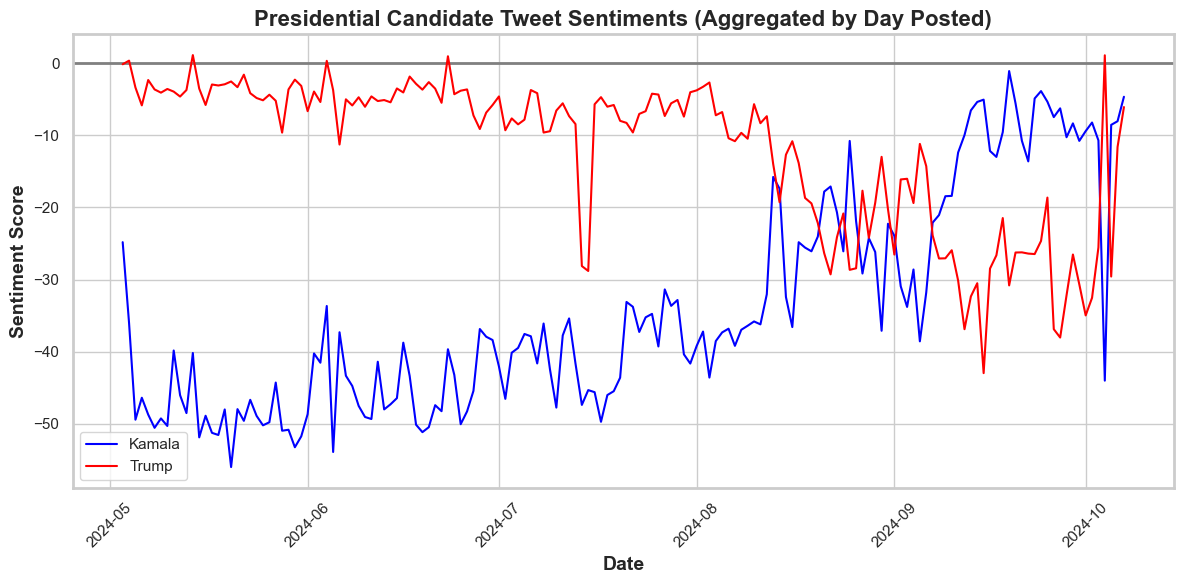

In [65]:
# Set the Seaborn style
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))
plt.axhline(y=0, color='gray', linestyle='-', linewidth=2)
sns.lineplot(data=df, x=daily_avg['Day'], y=daily_avg['Kamala_Score'], color='blue', label='Kamala')
sns.lineplot(data=df, x=daily_avg['Day'], y=daily_avg['Trump_Score'], color='red', label='Trump')

# Customize the plot
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
plt.title('Presidential Candidate Tweet Sentiments (Aggregated by Day Posted)', fontsize=16,fontweight='bold')
plt.xlabel('Date',fontsize=14,fontweight='bold')
plt.ylabel('Sentiment Score',fontsize=14,fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

# Save the plot
plt.savefig('daily_average_sentiment_scores_timescale.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution

Shortened Time Scale with Simple Moving Average (window=5)

In [71]:
daily_avg['Kamala_Score_SMA_5'] = daily_avg.iloc[:,1].rolling(window=5).mean()
daily_avg['Trump_Score_SMA_5'] = daily_avg.iloc[:,2].rolling(window=5).mean()

daily_avg.head()

,Day,Kamala_Score,Trump_Score,Kamala_Score_SMA_5,Trump_Score_SMA_5
0,2024-05-03,-24.814815,-0.134680,NaN,NaN
1,2024-05-04,-36.048951,0.369630,NaN,NaN
2,2024-05-05,-49.447395,-3.359889,NaN,NaN
3,2024-05-06,-46.399371,-5.836962,NaN,NaN
4,2024-05-07,-48.735467,-2.319835,-41.0892,-2.256347


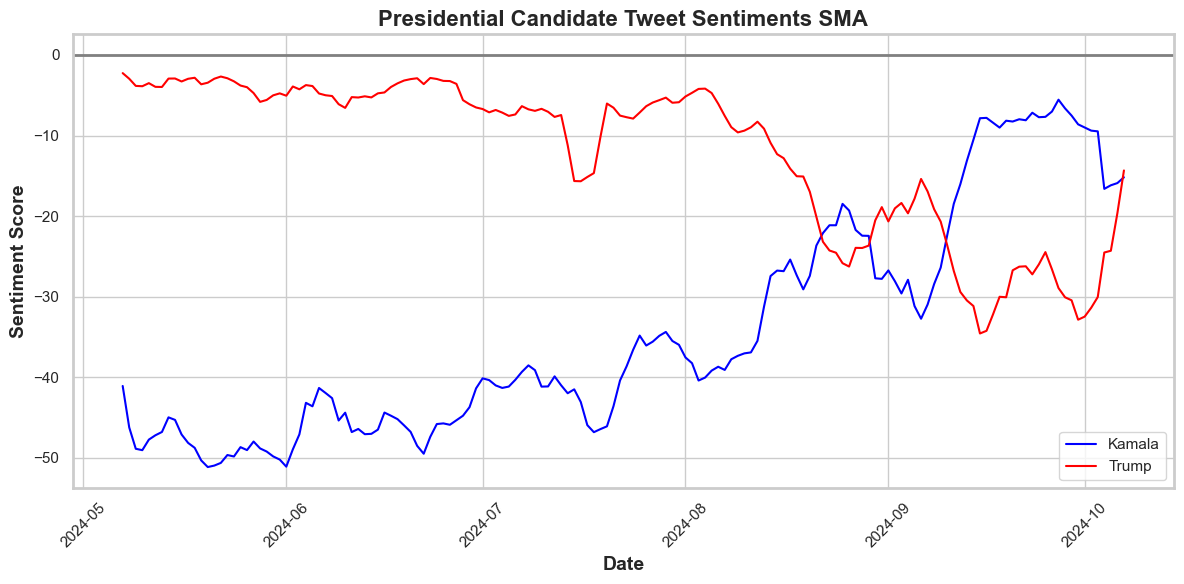

In [73]:
# Set the Seaborn style
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))
plt.axhline(y=0, color='gray', linestyle='-', linewidth=2)
sns.lineplot(data=df, x=daily_avg['Day'][4:], y=daily_avg['Kamala_Score_SMA_5'][4:], color='blue', label='Kamala')
sns.lineplot(data=df, x=daily_avg['Day'][4:], y=daily_avg['Trump_Score_SMA_5'][4:], color='red', label='Trump')

# Plot customizations
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
plt.title('Presidential Candidate Tweet Sentiments SMA', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Sentiment Score', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

plt.savefig('sentiment_scores_timescale_SMA.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution